In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from scipy.io import loadmat
import numpy as np

# Dosyaların yolları
data_path = "/content/drive/MyDrive/proje2/datasets/houston/data.mat"
gt_path   = "/content/drive/MyDrive/proje2/datasets/houston/mask_train.mat"

# Verileri yükleme
data = loadmat(data_path)['data']
gt   = loadmat(gt_path)['mask_train']

#print("Data shape:", data.shape) # (512, 217, 204)
#print("GT shape:", gt.shape)     # (512, 217)

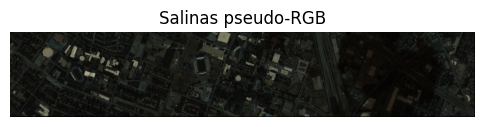

In [7]:
#VERİLERİ GÖRSELEŞTİRME (RGB İLE İLK 3 BANT)

import matplotlib.pyplot as plt

# Basit RGB benzeri görüntü (örnek olarak bant 30, 50, 70)
rgb = np.stack([data[:,:,30], data[:,:,50], data[:,:,70]], axis=2)
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # normalize et

plt.figure(figsize=(6,6))
plt.imshow(rgb)
plt.title("Salinas pseudo-RGB")
plt.axis('off')
plt.show()

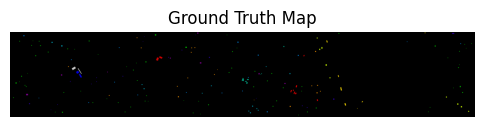

In [8]:
#ETIKET HARITASI

plt.figure(figsize=(6,6))
plt.imshow(gt, cmap='nipy_spectral')
plt.title("Ground Truth Map")
plt.axis('off')
plt.show()

In [9]:
from sklearn.decomposition import PCA

def applyMNF(data, n_components):
  # HSI verisini 2D hale getir
  h, w, b = data.shape
  data_2d = data.reshape(-1, b)  # (512*217, 204)

  # PCA ile MNF benzeri azaltma (ilk 10 bileşeni alıyoruz)
  pca = PCA(n_components=n_components)
  data_mnf = pca.fit_transform(data_2d)

  # 3D formata geri getir
  data_mnf_3d = data_mnf.reshape(h, w, -1)

  return data_mnf_3d

In [10]:
n_components = 10
mnf_data = applyMNF(data, n_components)
print("MNF Data shape:", mnf_data.shape)

MNF Data shape: (349, 1905, 10)


In [11]:
# Geçerli (sınıflı) pikselleri seç
mask = gt > 0
X = mnf_data[mask]    # Özellikler
y = gt[mask]          # Etiketler

num_classes = len(np.unique(y))

print(num_classes)
print(X.shape)
print(y.shape)

15
(2832, 10)
(2832,)


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Pencere boyutu ve padding hesaplama
window_size = 5
pad = window_size // 2  # 5//2 = 2

# MNF verisini normalize et
h, w, c = mnf_data.shape
mnf_2d = mnf_data.reshape(-1, c)
scaler = StandardScaler()
mnf_normalized = scaler.fit_transform(mnf_2d).reshape(h, w, c)

# MNF verisini padding ile genişlet
# reflect mode: kenarları aynalayarak genişletir
mnf_padded = np.pad(mnf_normalized, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')
print(f"Original shape: {mnf_normalized.shape}")
print(f"Padded shape: {mnf_padded.shape}")  # (512+4, 217+4, 10) = (516, 221, 10)

# Her piksel için 5×5 pencere oluştur
def create_patches(data_padded, gt, window_size):
    h, w = gt.shape  # Orijinal boyutlar
    pad = window_size // 2
    patches = []
    labels = []

    for i in range(h):
        for j in range(w):
            if gt[i, j] > 0:  # Sadece etiketli pikseller
                # Padded veriden pencere al
                patch = data_padded[i:i+window_size, j:j+window_size, :]
                patches.append(patch)
                labels.append(gt[i, j])

    return np.array(patches), np.array(labels)

print("\nPencereler oluşturuluyor...")
X_patches, y_patches = create_patches(mnf_padded, gt, window_size)
print(f"Patches shape: {X_patches.shape}")  # (num_samples, 5, 5, 10)
print(f"Labels shape: {y_patches.shape}")

# Train-test split
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_patches, y_patches, test_size=0.95, random_state=42, stratify=y_patches
)

# Etiketleri 0'dan başlat (keras için)
y_train_cnn = y_train_cnn - 1
y_test_cnn = y_test_cnn - 1

print(f"Train: {X_train_cnn.shape}, Test: {X_test_cnn.shape}")

# CNN Modeli
model = keras.Sequential([
    # Layer 1
    layers.Conv2D(32, (2, 2), strides=1, padding='same',
                  input_shape=(window_size, window_size, n_components)),
    layers.BatchNormalization(),
    layers.Activation('tanh'),
    layers.Dropout(0.3),

    # Layer 2
    layers.Conv2D(16, (2, 2), strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('tanh'),
    layers.Dropout(0.3),

    # Flatten ve Classification
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

# Model derleme
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Model eğitimi
print("\nCNN eğitiliyor...")
history = model.fit(
    X_train_cnn, y_train_cnn,
    batch_size=128,
    epochs=100,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

# Test
y_pred_cnn = model.predict(X_test_cnn, verbose=0)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

# Performans metrikleri
cnn_oa = accuracy_score(y_test_cnn, y_pred_cnn) * 100
cnn_kappa = cohen_kappa_score(y_test_cnn, y_pred_cnn) * 100

cm_cnn = confusion_matrix(y_test_cnn, y_pred_cnn)
class_acc_cnn = cm_cnn.diagonal() / cm_cnn.sum(axis=1)
cnn_aa = np.mean(class_acc_cnn) * 100

print(f"\n{'='*60}")
print(f"CNN Spektral -> OA: {cnn_oa:.2f}%, AA: {cnn_aa:.2f}%, Kappa: {cnn_kappa:.2f}%")
print(f"{'='*60}")

Original shape: (349, 1905, 10)
Padded shape: (353, 1909, 10)

Pencereler oluşturuluyor...
Patches shape: (2832, 5, 5, 10)
Labels shape: (2832,)
Train: (141, 5, 5, 10), Test: (2691, 5, 5, 10)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 5, 5, 32)       │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 5, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 5, 5, 16)       │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 5, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │         6,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,583 (37.43 KB)

 Trainable params: 9,487 (37.06 KB)

 Non-trainable params: 96 (384.00 B)


CNN eğitiliyor...
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0588 - loss: 3.0901 - val_accuracy: 0.0455 - val_loss: 2.7650 - learning_rate: 0.0100
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.1345 - loss: 2.9310 - val_accuracy: 0.0455 - val_loss: 2.6638 - learning_rate: 0.0100
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.0924 - loss: 2.9003 - val_accuracy: 0.0455 - val_loss: 2.5328 - learning_rate: 0.0100
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.1429 - loss: 2.5792 - val_accuracy: 0.0909 - val_loss: 2.3879 - learning_rate: 0.0100
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.2101 - loss: 2.3626 - val_accuracy: 0.0909 - val_loss: 2.2443 - learning_rate: 0.0100
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.2689 - loss: 2.1779 - val_accuracy: 0.2727 - val_loss: 2.1128 - learning_rate: 0.0100
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.2773 - loss: 

In [13]:
from skimage.morphology import opening, closing, disk
from sklearn.decomposition import PCA

# 1. MNF’nin ilk 3 bileşenini al
mnf_first3 = mnf_data[:, :, :3]
h, w, c = mnf_first3.shape

# 2. Farklı SE (structuring element) boyutlarıyla açma/kapama
se_sizes = [1, 3, 5, 7, 9, 11, 15, 21, 25, 31]
emp_bands = []

print("EMP özellikleri oluşturuluyor...")

for i in range(c):  # her MNF bandı için
    band = mnf_first3[:, :, i]
    emp_band_list = [band]  # orijinal bandı da dahil et
    for s in se_sizes:
        se = disk(s)
        emp_band_list.append(opening(band, se))
        emp_band_list.append(closing(band, se))
    emp_bands.extend(emp_band_list)

# 3. EMP bandlarını 3D hale getir
emp_stack = np.stack(emp_bands, axis=-1)
print("EMP stack shape:", emp_stack.shape)

# 4. EMP verisine MNF (PCA ile) uygula, ilk 10 bileşeni al
pca = PCA(n_components=10)
emp_2d = emp_stack.reshape(-1, emp_stack.shape[-1])
emp_mnf = pca.fit_transform(emp_2d).reshape(h, w, -1)
print("EMP MNF shape:", emp_mnf.shape)

# 5. Artık EMP MNF verisini CNN için kullanabilirsin
emp_data = emp_mnf

EMP özellikleri oluşturuluyor...
EMP stack shape: (349, 1905, 63)
EMP MNF shape: (349, 1905, 10)


In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Pencere boyutu ve padding hesaplama
window_size = 5
pad = window_size // 2  # 5//2 = 2

# MNF verisini normalize et
h, w, c = emp_data.shape
mnf_2d = emp_data.reshape(-1, c)
scaler = StandardScaler()
mnf_normalized = scaler.fit_transform(mnf_2d).reshape(h, w, c)

# MNF verisini padding ile genişlet
# reflect mode: kenarları aynalayarak genişletir
mnf_padded = np.pad(mnf_normalized, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')
print(f"Original shape: {mnf_normalized.shape}")
print(f"Padded shape: {mnf_padded.shape}")  # (512+4, 217+4, 10) = (516, 221, 10)

# Her piksel için 5×5 pencere oluştur
def create_patches(data_padded, gt, window_size):
    h, w = gt.shape  # Orijinal boyutlar
    pad = window_size // 2
    patches = []
    labels = []

    for i in range(h):
        for j in range(w):
            if gt[i, j] > 0:  # Sadece etiketli pikseller
                # Padded veriden pencere al
                patch = data_padded[i:i+window_size, j:j+window_size, :]
                patches.append(patch)
                labels.append(gt[i, j])

    return np.array(patches), np.array(labels)

print("\nPencereler oluşturuluyor...")
X_patches, y_patches = create_patches(mnf_padded, gt, window_size)
print(f"Patches shape: {X_patches.shape}")  # (num_samples, 5, 5, 10)
print(f"Labels shape: {y_patches.shape}")

# Train-test split
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_patches, y_patches, test_size=0.95, random_state=42, stratify=y_patches
)

# Etiketleri 0'dan başlat (keras için)
y_train_cnn = y_train_cnn - 1
y_test_cnn = y_test_cnn - 1

print(f"Train: {X_train_cnn.shape}, Test: {X_test_cnn.shape}")

# CNN Modeli
model = keras.Sequential([
    # Layer 1
    layers.Conv2D(32, (2, 2), strides=1, padding='same',
                  input_shape=(window_size, window_size, n_components)),
    layers.BatchNormalization(),
    layers.Activation('tanh'),
    layers.Dropout(0.3),

    # Layer 2
    layers.Conv2D(16, (2, 2), strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('tanh'),
    layers.Dropout(0.3),

    # Flatten ve Classification
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

# Model derleme
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Model eğitimi
print("\nCNN eğitiliyor...")
history = model.fit(
    X_train_cnn, y_train_cnn,
    batch_size=128,
    epochs=100,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

# Test
y_pred_cnn = model.predict(X_test_cnn, verbose=0)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

# Performans metrikleri
cnn_oa = accuracy_score(y_test_cnn, y_pred_cnn) * 100
cnn_kappa = cohen_kappa_score(y_test_cnn, y_pred_cnn) * 100

cm_cnn = confusion_matrix(y_test_cnn, y_pred_cnn)
class_acc_cnn = cm_cnn.diagonal() / cm_cnn.sum(axis=1)
cnn_aa = np.mean(class_acc_cnn) * 100

print(f"\n{'='*60}")
print(f"CNN Spektral -> OA: {cnn_oa:.2f}%, AA: {cnn_aa:.2f}%, Kappa: {cnn_kappa:.2f}%")
print(f"{'='*60}")

Original shape: (349, 1905, 10)
Padded shape: (353, 1909, 10)

Pencereler oluşturuluyor...
Patches shape: (2832, 5, 5, 10)
Labels shape: (2832,)
Train: (141, 5, 5, 10), Test: (2691, 5, 5, 10)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 32)       │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 5, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 16)       │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 5, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         6,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,583 (37.43 KB)

 Trainable params: 9,487 (37.06 KB)

 Non-trainable params: 96 (384.00 B)


CNN eğitiliyor...
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0672 - loss: 3.2706 - val_accuracy: 0.0455 - val_loss: 2.9167 - learning_rate: 0.0100
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.0672 - loss: 3.2711 - val_accuracy: 0.0455 - val_loss: 2.8559 - learning_rate: 0.0100
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.0672 - loss: 3.1030 - val_accuracy: 0.0909 - val_loss: 2.7721 - learning_rate: 0.0100
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.0672 - loss: 2.9974 - val_accuracy: 0.0909 - val_loss: 2.6737 - learning_rate: 0.0100
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.1513 - loss: 2.7926 - val_accuracy: 0.1364 - val_loss: 2.5678 - learning_rate: 0.0100
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.1933 - loss: 2.5470 - val_accuracy: 0.1364 - val_loss: 2.4613 - learning_rate: 0.0100
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.3277 - loss: 

In [15]:
from skimage.filters import gabor

mnf_first3 = mnf_data[:, :, :3]
h, w, c = mnf_first3.shape

# Gabor parametreleri
frequencies = [0.1, 0.2, 0.3, 0.4]
thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]

gabor_bands = []

print("Gabor filtreleri uygulanıyor...")

for i in range(c):
    band = mnf_first3[:, :, i]
    for freq in frequencies:
        for theta in thetas:
            real, imag = gabor(band, frequency=freq, theta=theta)
            magnitude = np.sqrt(real**2 + imag**2)
            gabor_bands.append(magnitude)

# 3D hale getir
gabor_stack = np.stack(gabor_bands, axis=-1)
print("Gabor stack shape:", gabor_stack.shape)

# MNF (PCA ile) -> ilk 10 bileşen
pca = PCA(n_components=10)
gabor_2d = gabor_stack.reshape(-1, gabor_stack.shape[-1])
gabor_mnf = pca.fit_transform(gabor_2d).reshape(h, w, -1)
print("Gabor MNF shape:", gabor_mnf.shape)

# CNN'e girdi
gabor_data = gabor_mnf


Gabor filtreleri uygulanıyor...
Gabor stack shape: (349, 1905, 48)
Gabor MNF shape: (349, 1905, 10)


In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Pencere boyutu ve padding hesaplama
window_size = 5
pad = window_size // 2  # 5//2 = 2

# MNF verisini normalize et
h, w, c = gabor_data.shape
mnf_2d = gabor_data.reshape(-1, c)
scaler = StandardScaler()
mnf_normalized = scaler.fit_transform(mnf_2d).reshape(h, w, c)

# MNF verisini padding ile genişlet
# reflect mode: kenarları aynalayarak genişletir
mnf_padded = np.pad(mnf_normalized, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')
print(f"Original shape: {mnf_normalized.shape}")
print(f"Padded shape: {mnf_padded.shape}")  # (512+4, 217+4, 10) = (516, 221, 10)

# Her piksel için 5×5 pencere oluştur
def create_patches(data_padded, gt, window_size):
    h, w = gt.shape  # Orijinal boyutlar
    pad = window_size // 2
    patches = []
    labels = []

    for i in range(h):
        for j in range(w):
            if gt[i, j] > 0:  # Sadece etiketli pikseller
                # Padded veriden pencere al
                patch = data_padded[i:i+window_size, j:j+window_size, :]
                patches.append(patch)
                labels.append(gt[i, j])

    return np.array(patches), np.array(labels)

print("\nPencereler oluşturuluyor...")
X_patches, y_patches = create_patches(mnf_padded, gt, window_size)
print(f"Patches shape: {X_patches.shape}")  # (num_samples, 5, 5, 10)
print(f"Labels shape: {y_patches.shape}")

# Train-test split
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_patches, y_patches, test_size=0.95, random_state=42, stratify=y_patches
)

# Etiketleri 0'dan başlat (keras için)
y_train_cnn = y_train_cnn - 1
y_test_cnn = y_test_cnn - 1

print(f"Train: {X_train_cnn.shape}, Test: {X_test_cnn.shape}")

# CNN Modeli
model = keras.Sequential([
    # Layer 1
    layers.Conv2D(32, (2, 2), strides=1, padding='same',
                  input_shape=(window_size, window_size, n_components)),
    layers.BatchNormalization(),
    layers.Activation('tanh'),
    layers.Dropout(0.3),

    # Layer 2
    layers.Conv2D(16, (2, 2), strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('tanh'),
    layers.Dropout(0.3),

    # Flatten ve Classification
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

# Model derleme
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Model eğitimi
print("\nCNN eğitiliyor...")
history = model.fit(
    X_train_cnn, y_train_cnn,
    batch_size=128,
    epochs=100,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

# Test
y_pred_cnn = model.predict(X_test_cnn, verbose=0)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

# Performans metrikleri
cnn_oa = accuracy_score(y_test_cnn, y_pred_cnn) * 100
cnn_kappa = cohen_kappa_score(y_test_cnn, y_pred_cnn) * 100

cm_cnn = confusion_matrix(y_test_cnn, y_pred_cnn)
class_acc_cnn = cm_cnn.diagonal() / cm_cnn.sum(axis=1)
cnn_aa = np.mean(class_acc_cnn) * 100

print(f"\n{'='*60}")
print(f"CNN Spektral -> OA: {cnn_oa:.2f}%, AA: {cnn_aa:.2f}%, Kappa: {cnn_kappa:.2f}%")
print(f"{'='*60}")

Original shape: (349, 1905, 10)
Padded shape: (353, 1909, 10)

Pencereler oluşturuluyor...
Patches shape: (2832, 5, 5, 10)
Labels shape: (2832,)
Train: (141, 5, 5, 10), Test: (2691, 5, 5, 10)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 32)       │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 5, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 16)       │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 5, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         6,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,583 (37.43 KB)

 Trainable params: 9,487 (37.06 KB)

 Non-trainable params: 96 (384.00 B)


CNN eğitiliyor...
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0588 - loss: 3.3272 - val_accuracy: 0.0909 - val_loss: 2.8258 - learning_rate: 0.0100
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.0924 - loss: 3.0539 - val_accuracy: 0.0909 - val_loss: 2.7974 - learning_rate: 0.0100
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.0756 - loss: 3.1627 - val_accuracy: 0.0909 - val_loss: 2.7576 - learning_rate: 0.0100
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.1008 - loss: 3.0092 - val_accuracy: 0.1364 - val_loss: 2.7107 - learning_rate: 0.0100
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.2101 - loss: 2.6533 - val_accuracy: 0.0909 - val_loss: 2.6640 - learning_rate: 0.0100
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2353 - loss: 2.4417 - val_accuracy: 0.0909 - val_loss: 2.6185 - learning_rate: 0.0100
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.2689 - loss: 

In [17]:
# Örnek: Spectral + EMP
stacked_data = np.concatenate((gabor_data, emp_data), axis=-1)

# veya Spectral + Gabor
# stacked_data = np.concatenate((mnf_data, gabor_data), axis=-1)

print("Stacked data shape:", stacked_data.shape)
stacked_data = stacked_data


Stacked data shape: (349, 1905, 20)


In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Pencere boyutu ve padding hesaplama
window_size = 5
pad = window_size // 2  # 5//2 = 2

# MNF verisini normalize et
h, w, c = stacked_data.shape
mnf_2d = stacked_data.reshape(-1, c)
scaler = StandardScaler()
mnf_normalized = scaler.fit_transform(mnf_2d).reshape(h, w, c)

# MNF verisini padding ile genişlet
# reflect mode: kenarları aynalayarak genişletir
mnf_padded = np.pad(mnf_normalized, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')
print(f"Original shape: {mnf_normalized.shape}")
print(f"Padded shape: {mnf_padded.shape}")  # (512+4, 217+4, 10) = (516, 221, 10)

# Her piksel için 5×5 pencere oluştur
def create_patches(data_padded, gt, window_size):
    h, w = gt.shape  # Orijinal boyutlar
    pad = window_size // 2
    patches = []
    labels = []

    for i in range(h):
        for j in range(w):
            if gt[i, j] > 0:  # Sadece etiketli pikseller
                # Padded veriden pencere al
                patch = data_padded[i:i+window_size, j:j+window_size, :]
                patches.append(patch)
                labels.append(gt[i, j])

    return np.array(patches), np.array(labels)

print("\nPencereler oluşturuluyor...")
X_patches, y_patches = create_patches(mnf_padded, gt, window_size)
print(f"Patches shape: {X_patches.shape}")  # (num_samples, 5, 5, 10)
print(f"Labels shape: {y_patches.shape}")

# Train-test split
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_patches, y_patches, test_size=0.95, random_state=42, stratify=y_patches
)

# Etiketleri 0'dan başlat (keras için)
y_train_cnn = y_train_cnn - 1
y_test_cnn = y_test_cnn - 1

print(f"Train: {X_train_cnn.shape}, Test: {X_test_cnn.shape}")

# CNN Modeli
model = keras.Sequential([
    # Layer 1
    layers.Conv2D(32, (2, 2), strides=1, padding='same',
                  input_shape=(window_size, window_size, 20)),
    layers.BatchNormalization(),
    layers.Activation('tanh'),
    layers.Dropout(0.3),

    # Layer 2
    layers.Conv2D(16, (2, 2), strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('tanh'),
    layers.Dropout(0.3),

    # Flatten ve Classification
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

# Model derleme
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Model eğitimi
print("\nCNN eğitiliyor...")
history = model.fit(
    X_train_cnn, y_train_cnn,
    batch_size=128,
    epochs=100,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

# Test
y_pred_cnn = model.predict(X_test_cnn, verbose=0)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

# Performans metrikleri
cnn_oa = accuracy_score(y_test_cnn, y_pred_cnn) * 100
cnn_kappa = cohen_kappa_score(y_test_cnn, y_pred_cnn) * 100

cm_cnn = confusion_matrix(y_test_cnn, y_pred_cnn)
class_acc_cnn = cm_cnn.diagonal() / cm_cnn.sum(axis=1)
cnn_aa = np.mean(class_acc_cnn) * 100

print(f"\n{'='*60}")
print(f"CNN Spektral -> OA: {cnn_oa:.2f}%, AA: {cnn_aa:.2f}%, Kappa: {cnn_kappa:.2f}%")
print(f"{'='*60}")

Original shape: (349, 1905, 20)
Padded shape: (353, 1909, 20)

Pencereler oluşturuluyor...
Patches shape: (2832, 5, 5, 20)
Labels shape: (2832,)
Train: (141, 5, 5, 20), Test: (2691, 5, 5, 20)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 5, 5, 32)       │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 5, 5, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 5, 16)       │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 5, 5, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         6,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,863 (42.43 KB)

 Trainable params: 10,767 (42.06 KB)

 Non-trainable params: 96 (384.00 B)


CNN eğitiliyor...
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1008 - loss: 2.9780 - val_accuracy: 0.0455 - val_loss: 2.7005 - learning_rate: 0.0100
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.0924 - loss: 3.0884 - val_accuracy: 0.0455 - val_loss: 2.6404 - learning_rate: 0.0100
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.0840 - loss: 2.8199 - val_accuracy: 0.0455 - val_loss: 2.5644 - learning_rate: 0.0100
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.1261 - loss: 2.7882 - val_accuracy: 0.0455 - val_loss: 2.4767 - learning_rate: 0.0100
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.2437 - loss: 2.5215 - val_accuracy: 0.0909 - val_loss: 2.3851 - learning_rate: 0.0100
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.2773 - loss: 2.2907 - val_accuracy: 0.0909 - val_loss: 2.2955 - learning_rate: 0.0100
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.3109 - loss: 